In [67]:
import pandas_datareader.data as pdr
import yfinance
import numpy as np

import cvxpy as cp
import datetime
import networkx as nx
import matplotlib.pyplot as plt

import opt

# Methods

In [68]:
def plot_graph(A, X, labels):
    G = nx.from_numpy_array(A)
    N = A.shape[0]
    A_pos = A[A>0]
    print('Nodes:', N)
    print('Mean degree:', np.sum(A)/N)
    print('Normalized number of edges: {:.3f}'.format(A_pos.size/A.size))
    print('Fro norm:', np.linalg.norm(A, 'fro'))

    print('Edge size: Mean: {:.4f} - std: {:.4f} - min: {:.4f} - median: {:.4f} - max: {:.4f}'.
           format(A_pos.mean(), np.std(A_pos), A_pos.min(), np.median(A_pos), A_pos.max()))

    plt.figure(figsize=(8,6))
    nx.draw_spring(G, node_color=X[:,0], labels=labels)

    plt.figure()
    plt.imshow(A)
    plt.colorbar()
    print(A.max(), A[A != 0].min())

In [69]:
def GMRF_GL(C, regs):
    N = C.shape[0]
    J = np.ones((N, N))/N
    L_hat = cp.Variable((N, N),  PSD=True)
    contraints = [cp.sum(L_hat, 0) == 0, L_hat[~np.eye(N, dtype=bool)] <= 0]
    
    obj = cp.Minimize(cp.trace(C@L_hat) - cp.log_det(L_hat + J)
    + regs['alpha']*cp.norm(L_hat[~np.eye(N, dtype=bool)], p=1))
    
    prob = cp.Problem(obj, contraints)

    try:      
        prob.solve()
    except cp.SolverError:
        print('WARNING: solver error')

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        print('WARNING: problem status', prob.status)

    return L_hat.value

In [70]:
def error_metrics(Y_hat, Y_test, H=None, H_gt=None, print_results=True):
    # Normalized error
    norm_y = (Y_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
    err_y = np.mean(((Y_test - Y_hat)**2).sum(1) / norm_y)
    
    # Direction prediction accuracy
    Y_hat_dir = (Y_hat > 0).astype(int)
    Y_test_dir = (Y_test > 0).astype(int)
    acc = (Y_hat_dir == Y_test_dir).mean()

    # Accumulated return
    if log_returns:
        acc_ret = 0
    else:
        acc_ret = 1.
    for i in range(Y_test.shape[1]):
        if log_returns:
            acc_ret += Y_test[np.argmax(Y_hat[:,i]),i]
        else:
            acc_ret *= 1. + Y_test[np.argmax(Y_hat[:,i]),i]
    if not log_returns:
        acc_ret -= 1

    if print_results:
        print(f"Error in signal y: {err_y}")
        print(f"Accuracy predicting direction of returns: {acc}")
        print(f"Accumulated return of simple portfolio (%): {acc_ret*100}")

    if H is not None and H_gt is not None:
        # Error wrt ground truth filter
        if H.ndim == 3: # Several filters
            norm_H = (H_gt**2).sum((1,2))
            err_H = np.mean(((H - H_gt)**2).sum((1,2)) / norm_H)
        else:
            norm_H = (H_gt**2).sum()
            err_H = ((H - H_gt)**2).sum() / norm_H

        if print_results:
            print(f"Error in filter: {err_H}")
        return err_y, acc, acc_ret, err_H

    return err_y, acc, acc_ret

# Downloading the data

In [71]:
tickers_25 = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "GOOG", "BRK-B", "UNH", "NVDA", "JNJ", "META", "XOM", "V", "JPM", "PG", "HD", "MA", "PFE", "CVX", "ABBV", "LLY", "KO", "BAC", "COST", "PEP"]
tickers_40 = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "GOOG", "BRK-B", "UNH", "NVDA", "JNJ", "META", "XOM", "V", "JPM", "PG", "HD", "MA", "PFE", "CVX", "ABBV", "LLY", "KO", "BAC", "COST", "PEP", "TMO", "MRK", "AVGO", "ADBE", "MCD", "ACN", "DIS", "VZ", "ABT", "CSCO", "WMT", "DHR", "CRM", "CMCSA", "NEE"]
tickers = tickers_25
N = len(tickers)

In [72]:
start = datetime.date(2016, 1, 1)
end = datetime.date(2019, 1, 1)
interval = "1d" # "1d" 1m 1wk 5d
int_start = datetime.date.today() - datetime.timedelta(days=59) # For intraday (interval 1m, 5m or 1h)
int_end = datetime.date.today()
prices = yfinance.download(tickers, start, end, interval=interval)["Adj Close"].dropna()[tickers]
#prices = pdr.DataReader(tickers, "yahoo", start, end)["Adj Close"].dropna()
log_returns = False
if log_returns:
    returns = np.log(prices) - np.log(prices.shift())
    returns.dropna(inplace=True)
else:
    returns = prices.pct_change().dropna()

pred_prices = True
if pred_prices:
    returns = prices.copy()

[*********************100%***********************]  25 of 25 completed


In [73]:
assert len(prices) > 0

# Building the graph

In [74]:
# Normalize X
X_sel = returns.values.copy()
X_norm = (X_sel - np.mean(X_sel, axis=0))/np.std(X_sel, axis=0)

C = np.cov(X_norm.T)
print('Norm C: {:.3f} - Max(C): {:.3f} - Min(C): {:.3f}'.format(np.linalg.norm(C), C.max(), C.min()))

Norm C: 19.793 - Max(C): 1.001 - Min(C): -0.075


In [75]:
regs2 = {'alpha': 1.75}
L = GMRF_GL(C, regs2)
A_GMRF = np.diag(np.diag(L)) - L
edge_th = .02 #.02
A_GMRF[A_GMRF < edge_th] = 0

In [76]:
((A_GMRF @ C - C @ A_GMRF)**2).sum() / ((C @ A_GMRF)**2).sum()

0.03801117451510268

Nodes: 25
Mean degree: 0.40300997647005765
Normalized number of edges: 0.531
Fro norm: 0.5784169009313408
Edge size: Mean: 0.0303 - std: 0.0093 - min: 0.0201 - median: 0.0283 - max: 0.0831
0.08312324708296318 0.020058119567421078


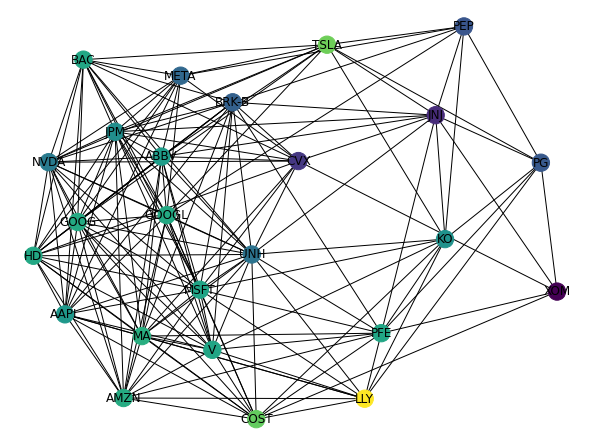

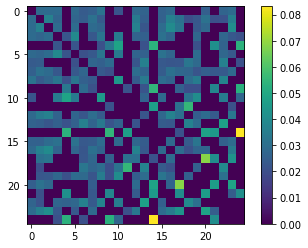

In [77]:
plot_graph(A_GMRF, X_norm.T, {i: tickers[i] for i in range(len(tickers))})

In [78]:
A_bin = A_GMRF.copy()
A_bin[A_bin > 0.] = 1.

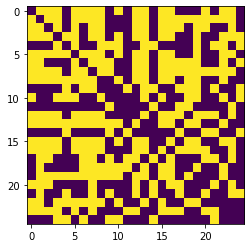

In [79]:
plt.imshow(A_bin)

In [80]:
# Empresas con las que tiene enlace Apple
[tickers[i] for i in np.where(A_bin.astype(bool)[0,:])[0]]

['MSFT',
 'AMZN',
 'GOOGL',
 'GOOG',
 'BRK-B',
 'UNH',
 'NVDA',
 'META',
 'V',
 'JPM',
 'HD',
 'MA',
 'LLY',
 'BAC',
 'COST']

# Splitting the data

In [81]:
Y = returns.values[1:,:].T
X = returns.values[:-1,:].T
ws = 1
X = returns.rolling(ws).mean().dropna().values[:-1,:].T # Last one can be predicted, as the rolling mean contains inside its return
Y = returns.values[ws:].T
N_dates = len(returns) - ws

train_test_split = 0.7
random_train_test = False
if random_train_test:
    idxs = np.random.permutation(N_dates)
else:
    idxs = np.arange(N_dates)

idxs_train = idxs[:int(train_test_split*N_dates)]
idxs_test = idxs[int(train_test_split*N_dates):]

X_train = X[:,idxs_train]
Y_train = Y[:,idxs_train]
X_test = X[:,idxs_test]
Y_test = Y[:,idxs_test]
X.shape, Y.shape, N_dates

((25, 754), (25, 754), 754)

In [82]:
np.savez('data_SP500/data_16-19_25-SP500', X=X, Y=Y, S=A_bin, C=C)

# Models

In [83]:
models = []
errs_y = []
accuracies_dir = []
acc_returns = []
errs_H = []

In [84]:
# Ground truth obtained using Least squares over all samples
H = cp.Variable((N,N))
obj = cp.sum_squares(Y_test - H @ X_test)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
H_gt = H.value

In [85]:
y_ls_perf = H_gt @ X_test
err_ls_per, acc_ls_per, acc_return_ls_per, err_H_ls_per = error_metrics(y_ls_perf, Y_test, H_gt, H_gt)
models.append("LS-Perfect (LB)"); errs_y.append(err_ls_per); accuracies_dir.append(acc_ls_per)#; acc_returns.append(acc_return_ls_per)

Error in signal y: 0.00026231567640350883
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 0.0


## Toy models for comparison

In [86]:
Y_random = Y_test.std(1)[:,None] * np.random.randn(*Y_test.shape) + Y_test.mean(1)[:,None]
err_random, acc_random, acc_return_random = error_metrics(Y_random, Y_test)
models.append("Random Return"); errs_y.append(err_random); accuracies_dir.append(acc_random); acc_returns.append(acc_return_random)

Error in signal y: 0.014281071064555652
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf


In [87]:
Y_zeros = np.zeros(Y_test.shape)
err_zeros, acc_zeros, acc_return_zeros = error_metrics(Y_zeros, Y_test)
models.append("Zero Return"); errs_y.append(err_zeros); accuracies_dir.append(acc_zeros); acc_returns.append(acc_return_zeros)

Error in signal y: 1.0000000000000024
Accuracy predicting direction of returns: 0.0
Accumulated return of simple portfolio (%): inf


In [88]:
# Identity - copying the temperature from the previous day
H_eye = np.eye(N)
Y_eye = H_eye @ X_test
err_eye, acc_eye, acc_return_eye = error_metrics(Y_eye, Y_test)
models.append("Copy Prev Day"); errs_y.append(err_eye); accuracies_dir.append(acc_eye); acc_returns.append(acc_return_eye)

Error in signal y: 0.00032103240046613043
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf


In [89]:
(prices['AAPL'][-1] - prices['AAPL'][int(train_test_split*N_dates)+1])/prices['AAPL'][int(train_test_split*N_dates)+1]

-0.017921830932838657

## Least squares

In [90]:
# Least squares
H = cp.Variable((N,N))
obj = cp.sum_squares(Y_train - H @ X_train)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
H_ls = H.value

In [91]:
# Least squares
H = cp.Variable((N,N))
obj = cp.sum_squares(Y_train - H @ Y_train)
constraints = [cp.diag(H) == 0]
prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve()
H_ls = H.value

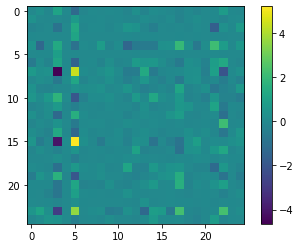

In [92]:
plt.imshow(H_ls)
plt.colorbar()

In [93]:
print("ON TRAIN DATA")
Y_hat_ls_train = H_ls @ Y_train # OJO Mirar
err_y_ls, acc_ls, acc_ret_ls, err_H_ls = error_metrics(Y_hat_ls_train, Y_train, H_ls, H_gt)
err_y_ls, acc_ls, acc_ret_ls, err_H_ls

ON TRAIN DATA
Error in signal y: 0.0005167848590136439
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 4.026640725936416


(0.0005167848590136439, 1.0, inf, 4.026640725936416)

In [94]:
norm_y = (Y_train**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y = ((Y_train - Y_hat_ls_train)**2).sum(1) / norm_y
err_y

array([6.76012665e-04, 2.08802410e-04, 7.94782867e-04, 8.71772393e-06,
       3.61372388e-03, 7.27365762e-06, 1.33247726e-04, 2.75536820e-04,
       2.79409491e-03, 2.62566277e-04, 4.35872966e-04, 1.77549120e-04,
       9.78031933e-05, 9.52098225e-05, 1.62194329e-04, 2.82315201e-04,
       1.32299840e-04, 2.41382059e-04, 2.70978498e-04, 5.83174297e-04,
       5.53388896e-04, 1.61860727e-04, 1.98047881e-04, 6.40043542e-04,
       1.12742165e-04])

In [95]:
Y_hat_ls = H_ls @ X_test
err_y_ls, acc_ls, acc_ret_ls, err_H_ls = error_metrics(Y_hat_ls, Y_test, H_ls, H_gt)
models.append("Least Squares"); errs_y.append(err_y_ls); accuracies_dir.append(acc_ls); acc_returns.append(acc_ret_ls); errs_H.append(err_H_ls)

Error in signal y: 0.023277409764859813
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 4.026640725936416


In [96]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A_GMRF, k) for k in range(K)])
h = cp.Variable(K)
obj = cp.sum_squares(Y_train - cp.sum([h[k] * Spow[k,:,:] for k in range(K)]) @ X_train)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
h = h.value
H_ls_gf = np.sum([h[k] * Spow[k,:,:] for k in range(K)], 0)

In [97]:
Y_hat_ls_gf = H_ls_gf @ X_test
err_y_ls_gf, acc_ls_gf, acc_ret_ls_gf, err_H_ls_gf = error_metrics(Y_hat_ls_gf, Y_test, H_ls_gf, H_gt)
models.append("Least Squares-GF"); errs_y.append(err_y_ls_gf); accuracies_dir.append(acc_ls_gf); acc_returns.append(acc_ret_ls_gf); errs_H.append(err_H_ls_gf)

Error in signal y: 0.0003224156800546698
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 0.8787759944300727


## Iterative (robust) algorithms

In [98]:
args = [0.4, 0.008, 0.0005, 3.]
args_no_st = [0.03, 0.005, 0., 3.5]
args_rew = [0.2, 0.1, 0.001, 0.0001, 1.1]
args_rew_no_st = [0.1, 0.08, 0., 5e-4, 1.]

In [99]:
iter, H_iter, S_iter = opt.estH_iter(X, Y, A_GMRF, C, args)

In [100]:
Y_hat_iter = H_iter @ X_test
err_iter, acc_iter, acc_ret_iter, err_H_iter = error_metrics(Y_hat_iter, Y_test, H_iter, H_gt)
models.append("RGFI"); errs_y.append(err_iter); accuracies_dir.append(acc_iter); acc_returns.append(acc_ret_iter); errs_H.append(err_H_iter)

Error in signal y: 0.0003136166997550396
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 0.8672971447309379


In [101]:
iter, H_iter_rew, S_iter_rew = opt.estH_iter_rew(X, Y, A_GMRF, C, args_rew)

In [102]:
Y_hat_iter_rew = H_iter_rew @ X_test
err_iter_rew, acc_iter_rew, acc_ret_iter_rew, err_H_iter_rew = error_metrics(Y_hat_iter_rew, Y_test, H_iter_rew, H_gt)
models.append("RGFI-REW"); errs_y.append(err_iter_rew); accuracies_dir.append(acc_iter_rew); acc_returns.append(acc_ret_iter_rew); errs_H.append(err_H_iter_rew)

Error in signal y: 0.0003136167176848428
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 0.8672973372293


In [103]:
((S_iter - A_GMRF)**2).sum()

7.304255862006781e-13

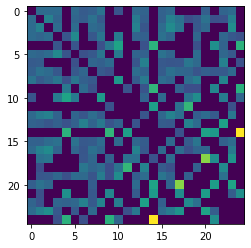

In [104]:
plt.imshow(S_iter)

# Multiple filters ARMA model

In [105]:
P = 4
Xs = np.array([returns.values[p:-P+p,:].T for p in range(P)])
Y_mult = returns.values[P:,:].T
N_dates_mult = Y_mult.shape[1]
Xs.shape, Y_mult.shape

((4, 25, 751), (25, 751))

In [106]:
idxs_mult = idxs.copy() # Using same split as in the previous cases, but needs to be adapted
for p in range(N_dates-P, N_dates): # Deleting invalid occurrences for this case
    idxs_mult = idxs_mult[idxs_mult != p]
idxs_train = idxs_mult[:int(train_test_split*N_dates_mult)]
idxs_test = idxs_mult[int(train_test_split*N_dates_mult):]
Xs_train = Xs[:,:,idxs_train]
Xs_test = Xs[:,:,idxs_test]
Y_mult_train = Y_mult[:,idxs_train]
Y_mult_test = Y_mult[:,idxs_test]

In [107]:
np.savez('data_SP500/data_mult_16-19_25-SP500', Xs=Xs, Y_mult=Y_mult, S=A_GMRF, C=C)

In [108]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_test - cp.sum([Hs[p] @ Xs_test[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_gt = np.array([Hs[p].value for p in range(P)])

In [109]:
Y_hat_perf = np.sum(Hs_gt @ Xs_test, 0)
err_mult_per, acc_mult_per, acc_return_mult_per = error_metrics(Y_hat_perf, Y_mult_test)
models.append("VARMA-LS-Perfect"); errs_y.append(err_mult_per); accuracies_dir.append(acc_mult_per)#; acc_returns.append(acc_return_mult_per)

Error in signal y: 0.00014480417507941768
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf


## Least squares

In [110]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_ls = np.array([Hs[p].value for p in range(P)])

In [111]:
Y_hat_mult_ls = np.sum(Hs_ls @ Xs_test, 0)
err_mult_ls, acc_mult_ls, acc_ret_mult_ls, err_H_mult_ls = error_metrics(Y_hat_mult_ls, Y_mult_test, Hs_ls, Hs_gt)
models.append("VARMA-LS"); errs_y.append(err_mult_ls); accuracies_dir.append(acc_mult_ls); acc_returns.append(acc_ret_mult_ls); errs_H.append(err_H_mult_ls)

Error in signal y: 0.0011832665710757265
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 1.4686061973892048


In [112]:
# Least squares postulating it is a graph filter
K = 5
hs = [cp.Variable(K) for _ in range(P)]
Hs = [cp.sum([hs[p][k] * Spow[k,:,:] for k in range(K)]) for p in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
hs_ls = np.array([hs[p].value for p in range(P)])
H_mult_ls_gf = np.array([np.sum([hs_ls[p,k] * Spow[k,:,:] for k in range(5)], 0) for p in range(P)])

In [113]:
Y_hat_mult_ls_gf = np.sum(H_mult_ls_gf @ Xs_test, 0)
err_y_mult_ls_gf, acc_mult_ls_gf, acc_ret_mult_ls_gf, err_H_mult_ls_gf = error_metrics(Y_hat_mult_ls_gf, Y_mult_test, H_mult_ls_gf, Hs_gt)
models.append("VARMA-LS-GF"); errs_y.append(err_y_mult_ls_gf); accuracies_dir.append(acc_mult_ls_gf); acc_returns.append(acc_ret_mult_ls_gf); errs_H.append(err_H_mult_ls_gf)

Error in signal y: 0.00032440047672804064
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 0.9898224060956664


## Iterative (robust) algorithms

In [114]:
from robustARMA_opt import estHs_iter, estHs_iter_rew

In [115]:
args = [0.2, 1e-3, 0.02, 1.6]
args_no_st = [0.4, 1e-3, 0., 1.5]
args_rew = [0.07, 1e-3, 0.1, 5e-4, 3.]
args_rew_no_st = [0.02, 1e-4, 0., 5e-4, 2.]

In [116]:
iter, Hs_iter, Ss_iter = estHs_iter(Xs_train, Y_mult_train, A_GMRF, C, args)

In [117]:
Y_hat_mult_iter = np.sum(Hs_iter @ Xs_test, 0)
err_mult_iter, acc_mult_iter, acc_ret_mult_iter, err_Hs_mult_iter = error_metrics(Y_hat_mult_iter, Y_mult_test, Hs_iter, Hs_gt)
models.append("VARMA-RGFI"); errs_y.append(err_mult_iter); accuracies_dir.append(acc_mult_iter); acc_returns.append(acc_ret_mult_iter); errs_H.append(err_Hs_mult_iter)

Error in signal y: 0.0008365952963694701
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 0.9921590849092992


In [118]:
iter, Hs_iter_rew, Ss_iter_rew = estHs_iter_rew(Xs_train, Y_mult_train, A_GMRF, C, args_rew)

In [119]:
Y_hat_mult_iter_rew = np.sum(Hs_iter_rew @ Xs_test, 0)
err_mult_iter_rew, acc_mult_iter_rew, acc_ret_mult_iter_rew, err_Hs_mult_iter_rew = error_metrics(Y_hat_mult_iter_rew, Y_mult_test, Hs_iter_rew, Hs_gt)
models.append("VARMA-RGFI-REW"); errs_y.append(err_mult_iter_rew); accuracies_dir.append(acc_mult_iter_rew); acc_returns.append(acc_ret_mult_iter_rew); errs_H.append(err_Hs_mult_iter_rew)

Error in signal y: 0.0008352744482950542
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf
Error in filter: 0.9920020601472221


# Representation

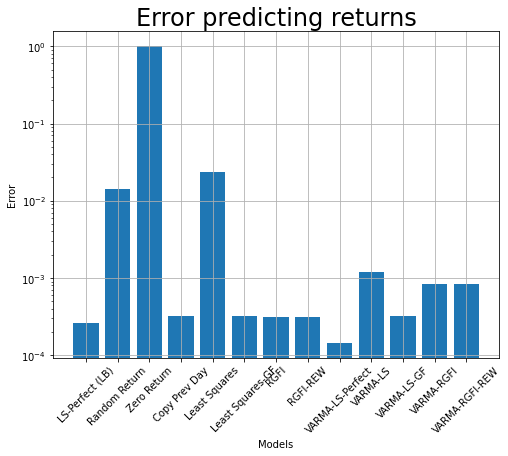

In [126]:
x_ax = np.arange(len(models))
plt.figure(figsize=(8,6))
plt.bar(x_ax, errs_y, log=True)
plt.xticks(x_ax, models, rotation=45)
plt.title("Error predicting returns", fontsize=24)
plt.xlabel("Models")
plt.ylabel("Error")
plt.grid()
#plt.ylim(0.7, 1.25)

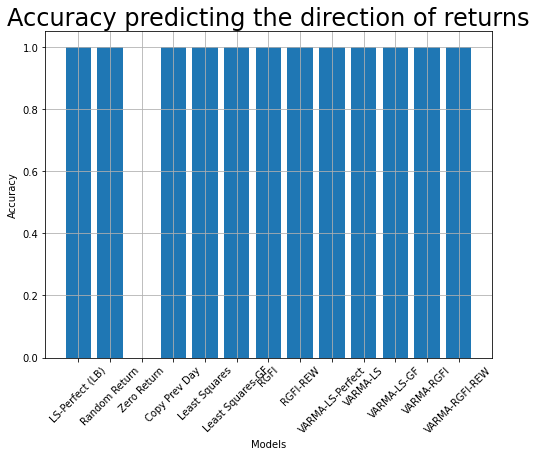

In [121]:
x_ax = np.arange(len(models))
plt.figure(figsize=(8,6))
plt.bar(x_ax, accuracies_dir)
plt.xticks(x_ax, models, rotation=45)
plt.title("Accuracy predicting the direction of returns", fontsize=24)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.grid()

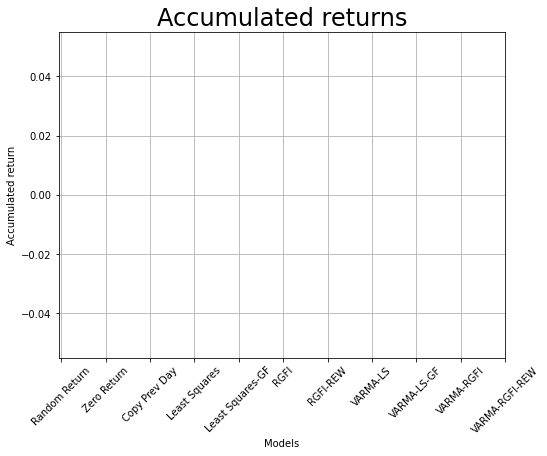

In [122]:
models2 = [models[i] for i in range(len(models)) if "Perfect" not in models[i]]
x_ax = np.arange(len(models2))
plt.figure(figsize=(8,6))
plt.bar(x_ax, acc_returns)
plt.xticks(x_ax, models2, rotation=45)
plt.title("Accumulated returns", fontsize=24)
plt.xlabel("Models")
plt.ylabel("Accumulated return")
plt.grid()

## VARMA Model

In [123]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [57]:
p = 2
q = 0
if random_train_test:
    print("WARNING: random train test split (not consecutive time samples), VARMA will not be comparable")
X_train_varma = X[:,:int(train_test_split*N_dates)].T
Y_test_varma = Y[:,int(train_test_split*N_dates):]
varma_model = VARMAX(X_train_varma, order=(p, q)).fit()

/home/vtenorio/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
Y_hat_varma = varma_model.forecast(steps=Y_test.shape[1]).T

In [59]:
Y_test_varma = Y[:,int(train_test_split*N_dates):]

Y_hat_varma.shape, Y_test_varma.shape

((25, 227), (25, 227))

In [60]:
err_varma, acc_varma, acc_ret_varma = error_metrics(Y_hat_varma, Y_test_varma)
err_varma, acc_varma, acc_ret_varma

Error in signal y: 0.07167354881416928
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf


(0.07167354881416928, 1.0, inf)

In [61]:
intercept = varma_model.params[:N]
coef_mats = varma_model.coefficient_matrices_var

In [62]:
Y_hat_varma2 = np.zeros(Y_test.shape)
start_idx = Y_train.shape[1]
for i in range(start_idx, N_dates):
    Y_hat_varma2[:,i-start_idx] = np.sum([coef_mats[k,:,:] @ X[:,i-k] for k in range(p)], axis=0) + intercept

In [63]:
err_varma2, acc_varma2, acc_ret_varma2 = error_metrics(Y_hat_varma2, Y_test_varma)
err_varma2, acc_varma2, acc_ret_varma2

Error in signal y: 0.0011626216272878818
Accuracy predicting direction of returns: 1.0
Accumulated return of simple portfolio (%): inf


(0.0011626216272878818, 1.0, inf)

# Representation

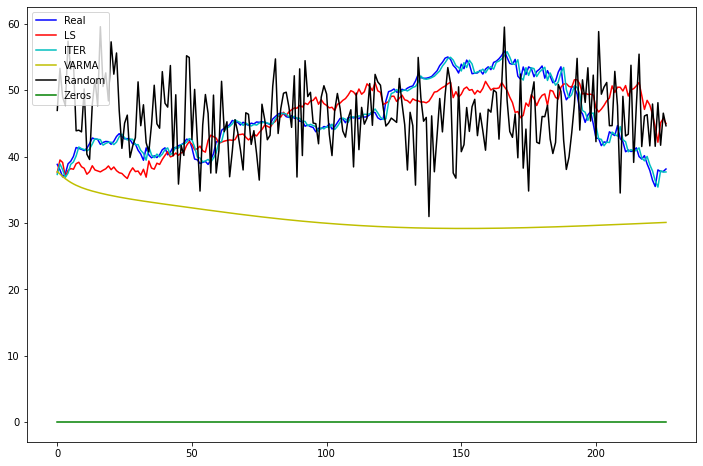

In [64]:
f, ax = plt.subplots(figsize=(12,8))

ax.plot(Y_test[0,:], c='b', label="Real")
ax.plot(Y_hat_ls[0,:], c='r', label="LS")
ax.plot(Y_hat_iter[0,:], c='c', label="ITER")
ax.plot(Y_hat_varma[0,:], c='y', label="VARMA")
ax.plot(Y_random[0,:], c='k', label="Random")
ax.plot(Y_zeros[0,:], c='g', label="Zeros")

ax.legend()

Text(0, 0.5, 'Error predicting returns')

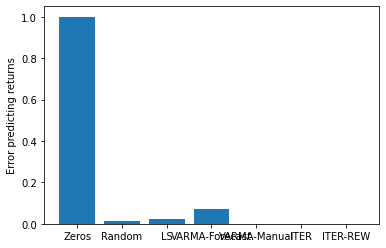

In [65]:
errs = [err_zeros, err_random, err_y_ls, err_varma, err_varma2, err_iter, err_iter_rew]
algs = ["Zeros", "Random", "LS", "VARMA-Forecast", "VARMA-Manual", "ITER", "ITER-REW"]
x_ax = np.arange(len(errs))
plt.bar(x_ax, errs)
plt.xticks(x_ax, algs)
plt.ylabel("Error predicting returns")

Text(0, 0.5, 'Accumulated return of simple portfolio')

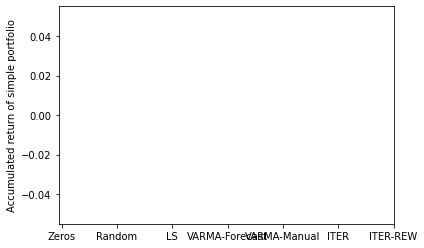

In [66]:
acc_rets = [acc_return_zeros, acc_return_random, acc_ret_ls, acc_ret_varma, acc_ret_varma2, acc_ret_iter, acc_ret_iter_rew]
algs = ["Zeros", "Random", "LS", "VARMA-Forecast", "VARMA-Manual", "ITER", "ITER-REW"]
x_ax = np.arange(len(acc_rets))
plt.bar(x_ax, acc_rets)
plt.xticks(x_ax, algs)
plt.ylabel("Accumulated return of simple portfolio")